In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from diagnostics.evaluation import fit_and_eval, rev_weighted_quad_kappa, error_rate
from imputers.zero_filler import ZeroFiller
from tools.datasets import get_boston, get_heart, get_houses, get_prudential
from sklearn.metrics import make_scorer, accuracy_score, f1_score, mean_squared_error
# from config import BINNER_CONFIG
from transformers import LabelsClipper, OutliersClipper, CustomOneHotEncoder, CustomBinner, CustomBinaryBinner, FeatureDropper
import warnings
warnings.filterwarnings('ignore')

In [3]:
# data, labels, continuous, discrete, dummy, categorical, target = get_boston()
data, labels, continuous, discrete, dummy, categorical, target, missing = get_heart()
# data, labels, continuous, discrete, dummy, categorical, target = get_houses()
# data, labels, continuous, discrete, dummy, categorical, target = get_prudential()

train = data.drop(target, axis=1)

9600     18
7200     14
6000     11
8400     11
9000     11
10800     9
9100      6
3182      6
7500      6
7800      6
Name: LotArea, dtype: int64
0.0 %


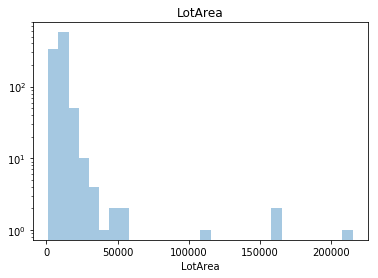

In [78]:
col = 'LotArea'
sns_plot = sns.distplot(data[col].dropna(), bins=30, kde=False,)
sns_plot.set_title(col)
sns_plot.get_figure().get_axes()[0].set_yscale('log')
print(data[col].value_counts().nlargest(10))
print(data[col].isnull().sum() * 100 / data.shape[0], '%')
# sns_plot.get_figure().savefig('./figures/basic_preprocessing/{}_hist.png'.format(col))

In [73]:
BINNER_CONFIG = {
    col: {'values': [train[col].max()]} for col in continuous + discrete
}
model = Pipeline([
        ('onehot',       CustomOneHotEncoder(columns=categorical)),
        ('binner', CustomBinaryBinner(BINNER_CONFIG)),
        ('zero_filler',  ZeroFiller()),
        # ('classifier',   LogisticRegression()),                # for Heart Disease
        # ('classifier',   LabelsClipper(LinearRegression())), # for Prudential
        ('regressor',    LinearRegression()),                # for Boston and Houses
])
# scores = cross_val_score(model, train.copy(), labels, cv=3, n_jobs=-1, scoring=make_scorer(accuracy_score))
scores = cross_val_score(model, train.copy(), labels, cv=KFold(3, shuffle=True, random_state=0), 
                         n_jobs=-1, scoring=make_scorer(mean_squared_error))
# scores = cross_val_score(model, train.copy(), labels, cv=3, n_jobs=-1, scoring=make_scorer(weighted_quad_kappa))
scores = np.sqrt(scores)
print('mean:', scores.mean(),'\nstd:', scores.std())


mean: 30938.59707448504 
std: 2576.632887526801


In [91]:
# i = 0
# fig, axes = plt.subplots(int(math.ceil(len(discrete)/3)), 3, figsize=(15,12))
# for attr in continuous:
#     clean = data[attr].dropna()
#     sns_plot = sns.distplot(clean, bins=100, kde=None, ax=axes[int(i/3)][i%3])
#     sns_plot.set_title(attr)
#     # sns_plot.get_figure().get_axes()[0].set_yscale('log')
#     axes[int(i/3)][i%3].set_yscale('log')
#     i += 1


In [131]:
labels_mean = labels.mean()
labels_std = labels.std()
filtered = train[(labels - labels_mean).abs() < labels_std]
y_filtered = labels[filtered.index]

In [7]:
from sklearn import clone

model = Pipeline([
        ('onehot',       CustomOneHotEncoder(columns=categorical)),
        ('zero_filler',  ZeroFiller()),
        ('classifier',   LogisticRegression()),                # for Heart Disease
        # ('classifier',   LabelsClipper(LinearRegression())), # for Prudential
        # ('regressor',    LinearRegression()),                # for Boston and Houses
])
# scores = cross_val_score(model, train.copy(), labels, cv=3, n_jobs=-1, scoring=make_scorer(accuracy_score))
# scores = cross_val_score(model, filtered.copy(), y_filtered, cv=KFold(3, shuffle=True, random_state=0), 
#                          n_jobs=-1, scoring=make_scorer(mean_squared_error))
# scores = cross_val_score(model, train.copy(), labels, cv=3, n_jobs=-1, scoring=make_scorer(weighted_quad_kappa))

fold = KFold(3, shuffle=True, random_state=0)
scores = []
for train_index, test_index in fold.split(data):
    X_test = train.loc[test_index]
    y_test = labels[test_index]
    mod = clone(model)
    
    data_train = data.loc[train_index]
    # filter outliers from train
    labels_mean = data_train[target].mean()
    labels_std = data_train[target].std()
    # data_filtered = data_train[(data_train[target] - labels_mean).abs() <  3 * labels_std]
    # X_train = data_filtered.drop(target, axis=1)
    # y_train = data_filtered[target]
    
    # clip train labels 
    # y_train = data_train[target]
    X_train = data_train.drop(target, axis=1)
    y_train = data_train[target].clip(labels_mean -  3 * labels_std, labels_mean + 3 * labels_std)
    
    mod.fit(X_train, y_train)
    y_pred = mod.predict(X_test)
    scores.append(error_rate(y_test, y_pred))
scores = np.array(scores)
print('mean:', scores.mean(),'\nstd:', scores.std())

mean: 0.16227685103892306 
std: 0.042597550837761594


In [9]:
model = Pipeline([
        ('onehot',       CustomOneHotEncoder(columns=categorical)),
        ('clipper', OutliersClipper(continuous)),
        ('zero_filler',  ZeroFiller()),
        # ('scaler', StandardScaler()),
        # ('classifier',   LogisticRegression()),                # for Heart Disease
        # ('classifier',   LabelsClipper(LinearRegression())), # for Prudential
        ('regressor',    LinearRegression()),                # for Boston and Houses
])
# scores = cross_val_score(model, train.copy(), labels, cv=3, n_jobs=-1, scoring=make_scorer(accuracy_score))
scores = cross_val_score(model, train.copy(), labels, cv=KFold(3, shuffle=True, random_state=0), 
                         n_jobs=-1, scoring=make_scorer(mean_squared_error))
# scores = cross_val_score(model, train.copy(), labels, cv=3, n_jobs=-1, scoring=make_scorer(weighted_quad_kappa))
scores = np.sqrt(scores)
print('mean:', scores.mean(),'\nstd:', scores.std())

mean: 36970.64381572234 
std: 3909.4386031808945


In [20]:
discrete

['age', 'slope', 'ca']

In [7]:
from transformers import *

poly = PolynomialsAdder(powers_per_column={col: [2] for col in continuous})
prod = FeatureProduct(columns=continuous)

In [10]:
X= prod.transform(train)

In [18]:
X[['chol*thalach', 'chol', 'thalach']]



,chol*thalach,chol,thalach
0,45423,309,147
1,40610,262,155
2,40560,240,169
3,31666,223,142
4,55770,330,169
5,32850,225,146
6,41827,277,151
7,35856,249,144
8,24265,211,115
9,29541,229,129
